<a href="https://colab.research.google.com/github/anorlo/Pytorch/blob/master/contextdesc2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip uninstall opencv-python
!pip uninstall opencv-contrib-python
!pip install opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)? y
  Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 30.6MB 106kB/s 


In [3]:
import cv2
cv2.__version__

'3.4.2'

In [3]:
import os
path = "/content/drive/My Drive/contextdesc2"

os.chdir(path)
os.listdir(path)

['contextdesc']

In [7]:
!git clone https://github.com/lzx551402/contextdesc.git

Cloning into 'contextdesc'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 262 (delta 92), reused 85 (delta 39), pack-reused 116
Receiving objects: 100% (262/262), 2.55 MiB | 11.93 MiB/s, done.
Resolving deltas: 100% (140/140), done.


In [13]:
% cd pretrained

/content/drive/My Drive/contextdesc2/contextdesc/pretrained


In [14]:
# ! wget https://research.altizure.com/data/contextdesc_models/contextdesc_pp.tar
! wget https://research.altizure.com/data/contextdesc_models/retrieval_model.tar

--2020-04-25 15:38:27--  https://research.altizure.com/data/contextdesc_models/retrieval_model.tar
Resolving research.altizure.com (research.altizure.com)... 13.35.126.75, 13.35.126.105, 13.35.126.23, ...
Connecting to research.altizure.com (research.altizure.com)|13.35.126.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 839434240 (801M) [application/x-tar]
Saving to: ‘retrieval_model.tar’

retrieval_model.tar 100%[===================>] 800.55M  11.7MB/s    in 83s     

2020-04-25 15:39:51 (9.65 MB/s) - ‘retrieval_model.tar’ saved [839434240/839434240]



In [15]:
# ! tar -xvf contextdesc_pp.tar
! tar -xvf retrieval_model.tar

retrieval_model/
retrieval_model/model.ckpt-550000.data-00000-of-00001
retrieval_model/reg.pb
retrieval_model/model.ckpt-550000.index


In [4]:
% cd contextdesc/

/content/drive/My Drive/contextdesc2/contextdesc


In [0]:
! python image_matching.py --h

Sampled 4838 from 4838
Sampled 5394 from 5394
SIFT feautre n_putative 4838 n_inlier 143
Raw local feature n_putative 4838 n_inlier 292
Augmented local feature n_putative 4838 n_inlier 831
[[ 0.10870049 -0.13579631  0.01734812 ...  0.11375947 -0.06336136
   0.1502423 ]
 [ 0.13691966 -0.09910382  0.09905247 ...  0.09766179 -0.01052666
   0.13907523]
 [ 0.08755077 -0.06351023  0.13221915 ... -0.02192625  0.12314437
   0.0939676 ]
 ...
 [ 0.1215324   0.12898014  0.13477199 ... -0.07503383  0.19396669
   0.03219323]
 [-0.01777744  0.12375983  0.132723   ... -0.06078507  0.24876161
  -0.08143643]
 [-0.04865129  0.29693314  0.06459615 ...  0.05634768 -0.00039321
   0.05839045]]
[[ 0.10870049 -0.13579631  0.01734812 ...  0.11375947 -0.06336136
   0.1502423 ]
 [ 0.13691966 -0.09910382  0.09905247 ...  0.09766179 -0.01052666
   0.13907523]
 [ 0.08755077 -0.06351023  0.13221915 ... -0.02192625  0.12314437
   0.0939676 ]
 ...
 [ 0.1215324   0.12898014  0.13477199 ... -0.07503383  0.19396669
   0.0

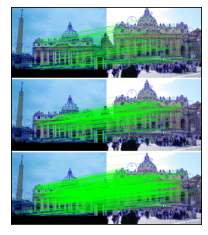

SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
#!/usr/bin/env python3
"""
Copyright 2019, Zixin Luo, HKUST.
Image matching example.
"""
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from utils.opencvhelper import MatcherWrapper

from models import get_model


FLAGS = tf.app.flags.FLAGS

tf.app.flags.DEFINE_string('loc_model', 'pretrained/contextdesc++',
                           """Path to the local feature and augmentation model.""")
tf.app.flags.DEFINE_string('reg_model', 'pretrained/retrieval_model',
                           """Path to the regional feature model.""")
tf.app.flags.DEFINE_string('img1_path', 'imgs/test_img1.jpg',
                           """Path to the first image.""")
tf.app.flags.DEFINE_string('img2_path', 'imgs/test_img2.jpg',
                           """Path to the second image.""")
tf.app.flags.DEFINE_integer('n_sample', 2048,
                            """Maximum number of keypoints. Sampled by octave.""")
# model options
tf.app.flags.DEFINE_string('model_type', 'pb',
                           """Pre-trained model type.""")
tf.app.flags.DEFINE_boolean('dense_desc', False,
                            """Whether to use dense descriptor model.""")
# matching options
tf.app.flags.DEFINE_boolean('ratio_test', False,
                            """Whether to apply ratio test in matching.""")
tf.app.flags.DEFINE_boolean('cross_check', False,
                            """Whether to apply cross check in matching.""")


def load_imgs(img_paths):
    rgb_list = []
    gray_list = []
    for img_path in img_paths:
        img = cv2.imread(img_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)[..., np.newaxis]
        img = img[..., ::-1]
        rgb_list.append(img)
        gray_list.append(gray)
    return rgb_list, gray_list


def extract_regional_features(rgb_list, model_path):
    reg_feat_list = []
    model = get_model('reg_model')(model_path)
    for _, val in enumerate(rgb_list):
        reg_feat = model.run_test_data(val)
        reg_feat_list.append(reg_feat)
    model.close()
    return reg_feat_list


def extract_local_features(gray_list, model_path):
    cv_kpts_list = []
    loc_info_list = []
    loc_feat_list = []
    sift_feat_list = []
    model = get_model('loc_model')(model_path, **{'sift_desc': True,
                                                  'n_sample': FLAGS.n_sample,
                                                  'peak_thld': 0.04,
                                                  'dense_desc': FLAGS.dense_desc,
                                                  'upright': False})
    for _, val in enumerate(gray_list):
        loc_feat, kpt_mb, normalized_xy, cv_kpts, sift_desc = model.run_test_data(val)
        raw_kpts = [np.array((i.pt[0], i.pt[1], i.size, i.angle, i.response)) for i in cv_kpts]
        raw_kpts = np.stack(raw_kpts, axis=0)
        loc_info = np.concatenate((raw_kpts, normalized_xy, loc_feat, kpt_mb), axis=-1)
        cv_kpts_list.append(cv_kpts)
        loc_info_list.append(loc_info)
        sift_feat_list.append(sift_desc)
        loc_feat_list.append(loc_feat / np.linalg.norm(loc_feat, axis=-1, keepdims=True))
    model.close()
    return cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list


def extract_augmented_features(reg_feat_list, loc_info_list, model_path):
    aug_feat_list = []
    model = get_model('aug_model')(model_path, **{'quantz': False})
    assert len(reg_feat_list) == len(loc_info_list)
    for idx, _ in enumerate(reg_feat_list):
        aug_feat, _ = model.run_test_data([reg_feat_list[idx], loc_info_list[idx]])
        aug_feat_list.append(aug_feat)
    model.close()
    return aug_feat_list


def main(argv=None):  # pylint: disable=unused-argument
    """Program entrance."""
    if FLAGS.model_type == 'pb':
        reg_model_path = os.path.join(FLAGS.reg_model, 'reg.pb')
        loc_model_path = os.path.join(FLAGS.loc_model, 'loc.pb')
        aug_model_path = os.path.join(FLAGS.loc_model, 'aug.pb')
    elif FLAGS.model_type == 'ckpt':
        reg_model_path = os.path.join(FLAGS.reg_model, 'model.ckpt-550000')
        loc_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
        aug_model_path = os.path.join(FLAGS.loc_model, 'model.ckpt-400000')
    else:
        raise NotImplementedError

    img_paths = [FLAGS.img1_path, FLAGS.img2_path]
    # load testing images.
    rgb_list, gray_list = load_imgs(img_paths)
    # extract regional features.
    reg_feat_list = extract_regional_features(rgb_list, reg_model_path)
    # extract local features and keypoint matchability.
    cv_kpts_list, loc_info_list, loc_feat_list, sift_feat_list = extract_local_features(
        gray_list, loc_model_path)
    # extract augmented features.
    aug_feat_list = extract_augmented_features(reg_feat_list, loc_info_list, aug_model_path)
    # feature matching and draw matches.
    matcher = MatcherWrapper()
    sift_match, sift_mask = matcher.get_matches(
        sift_feat_list[0], sift_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.8 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='SIFT feautre')

    base_match, base_mask = matcher.get_matches(
        loc_feat_list[0], loc_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='Raw local feature')

    aug_match, aug_mask = matcher.get_matches(
        aug_feat_list[0], aug_feat_list[1], cv_kpts_list[0], cv_kpts_list[1],
        ratio=0.89 if FLAGS.ratio_test else None, cross_check=FLAGS.cross_check,
        err_thld=3, ransac=True, info='Augmented local feature')
    # mine
    print(aug_feat_list[0])
    L = np.array(aug_feat_list[0])
    print(L)
    print(L.shape)
    #mine
    sift_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], sift_match, sift_mask)
    base_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], base_match, base_mask)
    aug_disp = matcher.draw_matches(
        rgb_list[0], cv_kpts_list[0], rgb_list[1], cv_kpts_list[1], aug_match, aug_mask)

    rows, cols = sift_disp.shape[0:2]
    white = (np.ones((int(rows / 50), cols, 3)) * 255).astype(np.uint8)
    disp = np.concatenate([sift_disp, white, base_disp, white, aug_disp], axis=0)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(disp)
    plt.show()


if __name__ == '__main__':
    tf.compat.v1.app.run()
